# Continous Frugal Flows

In this notebook we demonstrate the ability for Frugal Flows to identify Marginal Causal Effects

In [1]:
import sys
import os
sys.path.append("../") # go to parent dir

import jax
import jax.random as jr
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.stats as ss
import seaborn as sns
from sklearn.model_selection import KFold

from data.create_sim_data import simulate_data
from frugal_flows.causal_flows import get_independent_quantiles, train_frugal_flow
from frugal_flows.bijections import UnivariateNormalCDF

jax.config.update("jax_enable_x64", True)

## Checking for the Causal Effect

Generating Normalised Data

In [2]:
N = 10000

# marginal_Z = {
#     'Z1': ss.norm(loc=0, scale=1),
#     'Z2': ss.norm(loc=0, scale=1),
#     'Z3': ss.norm(loc=3, scale=5),
#     'Z4': ss.norm(loc=-1, scale=2),
#     # 'Z5': ss.norm(loc=0, scale=1)
# }
# corr_matrix = np.array([
#     [1, 0.8, 0.6, 0.2, 0.1],
#     [0.8, 1, 0.4, 0.2, 0.1],
#     [0.6, 0.4, 1, 0.1, 0.1],
#     [0.2, 0.2, 0.1, 1, 0.1],
#     [0.1, 0.1, 0.1, 0.1, 1]
# ])
# treatment_type = "D"
# outcome_type = "C"
# prop_score_weights = [1, 1, 1, 1]  # Check propscore weights are of same dim as Z
# causal_params = [1, 1]
# data_xdyc = simulate_data(N, corr_matrix, marginal_Z, prop_score_weights, "D", causal_params, "C")
# df_Z = scipy.stats.zscore(data_xdyc[['Z1', 'Z2', 'Z3', 'Z4']].values)

# Y = jnp.array(data_xdyc[['Y']].values)
# X = jnp.array(data_xdyc[['X']].values)
# Z = jnp.array(df_Z)

keys = jr.split(jr.PRNGKey(0), 3)


Z = jr.multivariate_normal(
    keys[1], 
    jnp.array([0.,0.,0.,0.,0.]), 
    jnp.array([
        [1, 0.8, 0.6, 0.2, 0.1],
        [0.8, 1, 0.4, 0.2, 0.1],
        [0.6, 0.4, 1, 0.1, 0.1],
        [0.2, 0.2, 0.1, 1, 0.1],
        [0.1, 0.1, 0.1, 0.1, 1]
    ]), 
    shape=(N,)
)
p = 1 / (
    1 + jnp.exp(-jnp.sum((Z) * 1 * jnp.ones(shape=(Z.shape[0], Z.shape[1])), axis=1))
)
X = jr.bernoulli(key=jr.PRNGKey(1), p=p).astype(int)[:, None]
Y = (jax.random.normal(keys[2], shape=(N,1)) + X + jnp.expand_dims(Z.sum(1), axis=1))

data_xdyc = pd.DataFrame(
    jnp.concat([Y, X, Z], axis=1),
    columns=['Y', 'X'] + [f"Z{i+1}" for i in range(Z.shape[1])]
)

res = get_independent_quantiles(
    key = jr.PRNGKey(3),
    # z_discr=jnp.expand_dims(z_discr,axis=1), #impose discrete
    z_cont=Z,
    RQS_knots=8,
    flow_layers=4,
    nn_width=10,
    nn_depth=4,
    max_epochs = 1000,
    max_patience=100,
    learning_rate=5e-3,
    return_z_cont_flow = True,
 )

 11%|███████████▏                                                                                        | 112/1000 [00:36<04:45,  3.11it/s, train=7.091908586820963, val=7.086195622164757 (Max patience reached)]


In [3]:
col_names = [f"U_Z{i}" for i in range(Z.shape[1])]
plot_data = pd.DataFrame(res['u_z_cont'], columns=col_names)
plot_data.head()

,U_Z0,U_Z1,U_Z2,U_Z3,U_Z4
0,0.240721,0.415231,0.261025,0.215752,0.363860
1,0.766818,0.382673,0.464738,0.204561,0.718624
2,0.869718,0.979971,0.639818,0.554562,0.913121
3,0.427251,0.547828,0.608286,0.599341,0.935607
4,0.573451,0.894248,0.858173,0.930090,0.349102


The correlation matrices have very close to the same entries but the rows and columns are permuted.

True Corr


Array([[1.        , 0.80461478, 0.60083401, 0.20691647, 0.07514457],
       [0.80461478, 1.        , 0.40938396, 0.21129742, 0.07353746],
       [0.60083401, 0.40938396, 1.        , 0.10836616, 0.08867653],
       [0.20691647, 0.21129742, 0.10836616, 1.        , 0.09527212],
       [0.07514457, 0.07353746, 0.08867653, 0.09527212, 1.        ]],      dtype=float64)

Flow Corr


Array([[1.        , 0.09485643, 0.20679364, 0.21078868, 0.10834389],
       [0.09485643, 1.        , 0.07497773, 0.07322401, 0.08866728],
       [0.20679364, 0.07497773, 1.        , 0.80428476, 0.60058854],
       [0.21078868, 0.07322401, 0.80428476, 1.        , 0.40936835],
       [0.10834389, 0.08866728, 0.60058854, 0.40936835, 1.        ]],      dtype=float64)

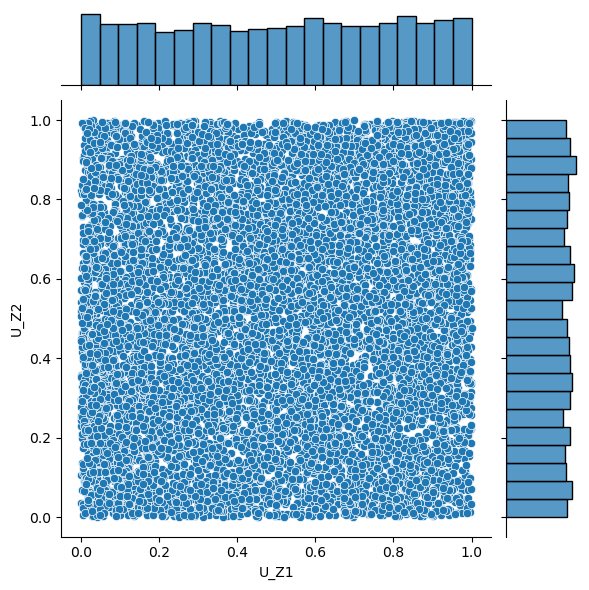

In [4]:
print("True Corr")
display(jnp.corrcoef(Z.T))
print("Flow Corr")
display(jnp.corrcoef(jax.scipy.special.ndtri(plot_data.values).T))
sns.jointplot(x='U_Z1', y='U_Z2', data=plot_data, kind="scatter");

## Check conditional effect

In [5]:
data_xdyc.head()

,Y,X,Z1,Z2,Z3,Z4,Z5
0,-2.131628,0.0,-0.652277,-0.723212,-0.312598,-0.696082,-0.238140
1,1.660706,1.0,-0.089176,-0.763641,0.615656,0.712791,-0.312808
2,5.018842,1.0,0.371217,0.186091,1.367624,1.121951,2.019721
3,2.825218,1.0,0.281504,0.312481,1.524439,-0.168810,0.076466
4,5.182771,1.0,1.058777,1.478673,-0.350652,0.195892,1.221202


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

df_reg = data_xdyc[['Y', 'X']]
encoder = OneHotEncoder(drop='first')
X_encoded = encoder.fit_transform(data_xdyc[['X']])
model = LinearRegression()
model.fit(X_encoded, df_reg['Y'])

print(f"Intercept: {model.intercept_}")
print(f"Coefficients: {model.coef_}")

Intercept: -2.2340605477567355
Coefficients: [5.52520886]


The data is indeed confounded.

### Training the Frugal FLow

In [7]:
def return_fits(frugal_flow):
    causal_margin = frugal_flow.bijection.bijections[-1].bijection.bijections[0]
    return {
        'ate': causal_margin.ate,
        'const': causal_margin.const,
        'scale': causal_margin.scale
    }

In [8]:
# frugal_flow, losses =  train_frugal_flow(
#     key=jr.PRNGKey(1),
#     y=jnp.array(Y),
#     u_z=res['u_z_cont'],
#     RQS_knots=4,
#     nn_depth=4,
#     nn_width=10,
#     flow_layers=1,
#     show_progress=True,
#     learning_rate=1e-2,
#     max_epochs=20000,
#     max_patience=100,
#     batch_size=100,
#     condition=jnp.array(X),
#  )

frugal_flow, losses = train_frugal_flow(key=jr.PRNGKey(1),
    y=Y,
    u_z=res['u_z_cont'],
    # u_z=res['u_z_cont'],
    learning_rate=5e-3,
    RQS_knots=8,
    nn_depth=4,
    nn_width=10,
    flow_layers=8,
    max_patience=70,
    max_epochs=10000,
    condition=X
 )

  2%|█▌                                                                                             | 162/10000 [01:33<1:34:47,  1.73it/s, train=0.6454681186864825, val=0.7143986614883202 (Max patience reached)]


In [9]:
return_fits(frugal_flow)

{'ate': Array(1.00722149, dtype=float64),
 'const': Array(0.06461248, dtype=float64),
 'scale': Array(3.45824249, dtype=float64)}

## Diagnostics

In [10]:
keys = jr.split(jr.PRNGKey(0), 3)
frugal_flow_samples_0 = frugal_flow.sample(keys[0], condition=jnp.zeros((5000,1))) #
frugal_flow_samples_1 = frugal_flow.sample(keys[1], condition=jnp.ones((5000,1))) #

### No correlation between $Y$ and $Z_1$ or $Z_2$

In [11]:
frugal_flow_samples_0 = frugal_flow_samples_0.at[:, 1:].set(jax.scipy.special.ndtri(frugal_flow_samples_0[:, 1:]))
frugal_flow_samples_1 = frugal_flow_samples_1.at[:, 1:].set(jax.scipy.special.ndtri(frugal_flow_samples_1[:, 1:]))

True Correlation Matrix:

Flow outputs:

In [12]:
jnp.corrcoef(frugal_flow_samples_0.T)

Array([[1.        , 0.45429034, 0.40030265, 0.79641675, 0.74026686,
        0.66692666],
       [0.45429034, 1.        , 0.06310706, 0.19914075, 0.19136981,
        0.13545716],
       [0.40030265, 0.06310706, 1.        , 0.09070393, 0.07195256,
        0.09583914],
       [0.79641675, 0.19914075, 0.09070393, 1.        , 0.80162648,
        0.61591817],
       [0.74026686, 0.19136981, 0.07195256, 0.80162648, 1.        ,
        0.42833872],
       [0.66692666, 0.13545716, 0.09583914, 0.61591817, 0.42833872,
        1.        ]], dtype=float64)

In [13]:
jnp.corrcoef(frugal_flow_samples_1.T)

Array([[1.        , 0.48728352, 0.39905879, 0.79856111, 0.74560424,
        0.6732984 ],
       [0.48728352, 1.        , 0.06707266, 0.23158523, 0.21878198,
        0.16558501],
       [0.39905879, 0.06707266, 1.        , 0.08270208, 0.09534955,
        0.09505769],
       [0.79856111, 0.23158523, 0.08270208, 1.        , 0.80711849,
        0.62058573],
       [0.74560424, 0.21878198, 0.09534955, 0.80711849, 1.        ,
        0.43378039],
       [0.6732984 , 0.16558501, 0.09505769, 0.62058573, 0.43378039,
        1.        ]], dtype=float64)

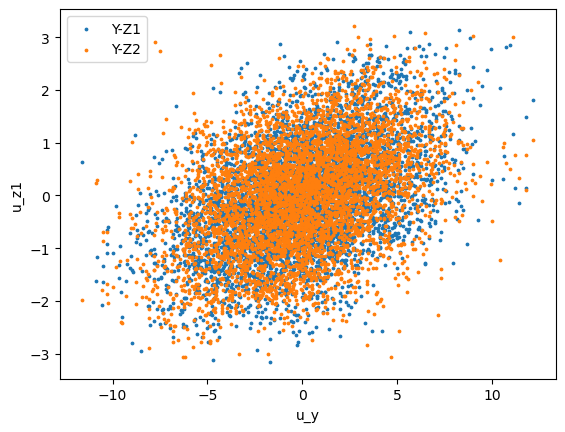

In [14]:
plt.scatter(*frugal_flow_samples_0[:,:2].T, label="Y-Z1", s=3)
plt.scatter(*frugal_flow_samples_0[:,[0,2]].T, label="Y-Z2", s=3)

# plt.scatter(*jax.scipy.special.ndtr(z).T, label="target", s=2)
plt.xlabel('u_y')
plt.ylabel('u_z1')
plt.legend()
plt.show()

In [15]:
plt.scatter(*frugal_flow_samples_0[:,1:].T, label="zero", s=2)
plt.scatter(*jax.scipy.special.ndtri(res['u_z_cont']).T, label="one", s=3)
plt.xlabel('u_z1')
plt.ylabel('u_z2')
plt.legend()
plt.show()

TypeError: scatter() got multiple values for argument 's'